<a href="https://colab.research.google.com/github/Joaof14/PCM-Cod/blob/main/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Sistema de Transmissão de Dados


## Pulse Code Modulation e Codificacao de Linha

### Configurando ambiente

In [1]:
#Importações de bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import warnings
warnings.filterwarnings("ignore")  # Ignorar avisos do matplotlib



In [2]:
# Configurações
n_bits = 8  # Bits por amostra
SNR_dB = np.arange(0, 20.5, 0.5)  # SNR de 0 a 20 dB em passos de 0.5 dB

### Leitura do Audio e Quantização PCM

In [3]:
# Leitura do arquivo de áudio (substitua pelo seu arquivo .wav)
fs_audio, sinal_analogico = wavfile.read('Better-Call-Saul-Intro.wav')

# Converter para mono se for estéreo
if sinal_analogico.ndim > 1:
    sinal_analogico = sinal_analogico[:, 0]  # Pega apenas o primeiro canal

# Normalização para [-1, 1]
sinal_analogico = sinal_analogico.astype(np.float64)
max_val = np.max(np.abs(sinal_analogico))
if max_val > 0:
    sinal_analogico /= max_val


# Quantização PCM (8 bits)
L = 2 ** n_bits
sinal_quantizado = np.round(sinal_analogico * (L/2 - 1)) / (L/2 - 1)



In [4]:
def pcm_encode(sinal, n_bits):
    # Converter para valores inteiros de 0 a 255
    sinal_flat = sinal.flatten()  # Garante array 1D
    valores_inteiros = ((sinal_flat + 1) * (2**n_bits - 1)/2).clip(0, 2**n_bits-1).round().astype(int)
    
    # Converte para binário
    binary_strings = []
    for x in valores_inteiros:
        # Formata para string binária com n_bits dígitos
        bin_str = bin(x)[2:]  # Remove o '0b' inicial
        bin_str = bin_str.zfill(n_bits)  # Preenche com zeros à esquerda
        binary_strings.append(bin_str)
    
    return binary_strings

# 5. Codificação
bits_pcm = pcm_encode(sinal_quantizado, n_bits)
bits_flat = np.array([int(bit) for palavra in bits_pcm for bit in palavra])


In [5]:
# Codificação On-Off: 1 → 1V, 0 → 0V
def codificacao_on_off(bits):
    return np.array(bits, dtype=np.float64)

# Codificação Polar: 1 → +1V, 0 → -1V
def codificacao_polar(bits):
    return 2 * np.array(bits, dtype=np.float64) - 1

# Codificação Manchester (idealizada): 1 → [1, -1], 0 → [-1, 1]
def codificacao_manchester(bits):
    bits_array = np.array(bits)
    manchester = np.empty(bits_array.size * 2)
    manchester[0::2] = 2 * bits_array - 1    # Primeiro meio-bit: 1 → +1, 0 → -1
    manchester[1::2] = -manchester[0::2]     # Segundo meio-bit é o inverso
    return manchester


In [6]:
# Aplicar codificação
sinal_on_off = codificacao_on_off(bits_flat)
sinal_polar = codificacao_polar(bits_flat)
sinal_manchester = codificacao_manchester(bits_flat)

### Transmissão em Canal AWGN e Deteccao

In [7]:
def transmissao_awgn(sinal_codificado, snr_db):
    potencia_sinal = np.mean(np.array(sinal_codificado) ** 2)
    potencia_ruido = potencia_sinal / (10 ** (snr_db / 10))
    ruido = np.random.normal(0, np.sqrt(potencia_ruido), len(sinal_codificado))
    sinal_ruidoso = sinal_codificado + ruido
    return sinal_ruidoso

def detector_limiar_np(sinal_recebido, limiar=0):
    return (sinal_recebido >= limiar).astype(int)

def calcular_ber(original_bits, recebidos_bits):
    return np.mean(original_bits != recebidos_bits)


### Calculo da taxa de erro de bit (BER) para cada codificacao

In [8]:
ber_on_off = []
ber_polar = []
ber_manchester = []

for snr in SNR_dB:
    # --- On-Off ---
    sinal_rx_on_off = transmissao_awgn(sinal_on_off, snr)
    bits_rx_on_off = detector_limiar_np(sinal_rx_on_off, limiar=0.5)
    ber_on_off.append(calcular_ber(bits_flat, bits_rx_on_off))

    # --- Polar ---
    sinal_rx_polar = transmissao_awgn(sinal_polar, snr)
    bits_rx_polar = detector_limiar_np(sinal_rx_polar, limiar=0)
    ber_polar.append(calcular_ber(bits_flat, bits_rx_polar))

    # --- Manchester ---
    sinal_rx_manchester = transmissao_awgn(sinal_manchester, snr)
    # Reconstruir bits pela média de cada par (duas amostras por bit)
    pares = sinal_rx_manchester.reshape(-1, 2)
    media_pares = np.mean(pares, axis=1)
    bits_rx_manchester = detector_limiar_np(media_pares, limiar=0)
    ber_manchester.append(calcular_ber(bits_flat, bits_rx_manchester))


### Grafico de BER x Relacao Sinal Ruído (SNR)

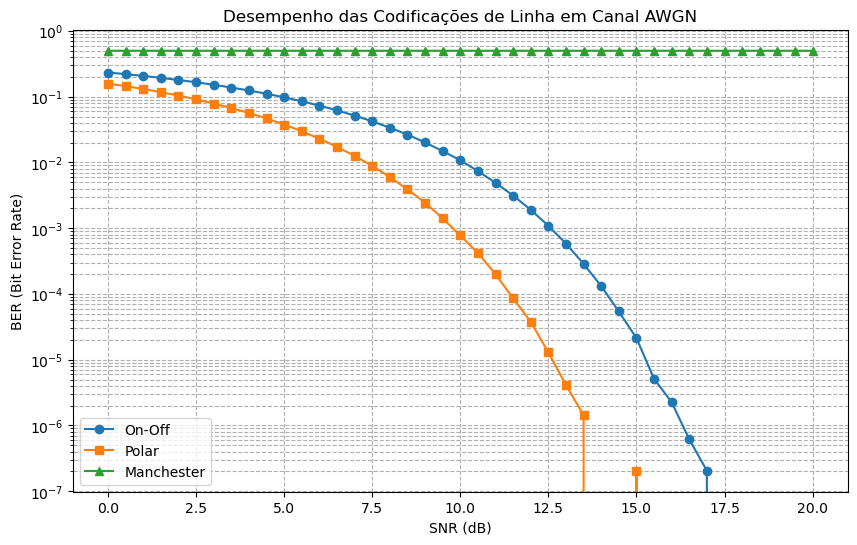

In [9]:
plt.figure(figsize=(10, 6))
plt.semilogy(SNR_dB, ber_on_off, label='On-Off', marker='o')
plt.semilogy(SNR_dB, ber_polar, label='Polar', marker='s')
plt.semilogy(SNR_dB, ber_manchester, label='Manchester', marker='^')
plt.xlabel('SNR (dB)')
plt.ylabel('BER (Bit Error Rate)')
plt.title('Desempenho das Codificações de Linha em Canal AWGN')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

#### Comentários

### plotar sinais codificados

In [10]:
# Selecionar um trecho de bits
n_bits_plot = 20
bits_amostra = bits_flat[:n_bits_plot]

# Codificar
sinal_on_off_plot = codificacao_on_off(bits_amostra)
sinal_polar_plot = codificacao_polar(bits_amostra)
sinal_manchester_plot = codificacao_manchester(bits_amostra)

# Criar eixo de tempo para Manchester (2 amostras por bit)
tempo_on_off = np.arange(len(sinal_on_off_plot))
tempo_polar = np.arange(len(sinal_polar_plot))
tempo_manchester = np.linspace(0, len(sinal_manchester_plot) / 2, len(sinal_manchester_plot))


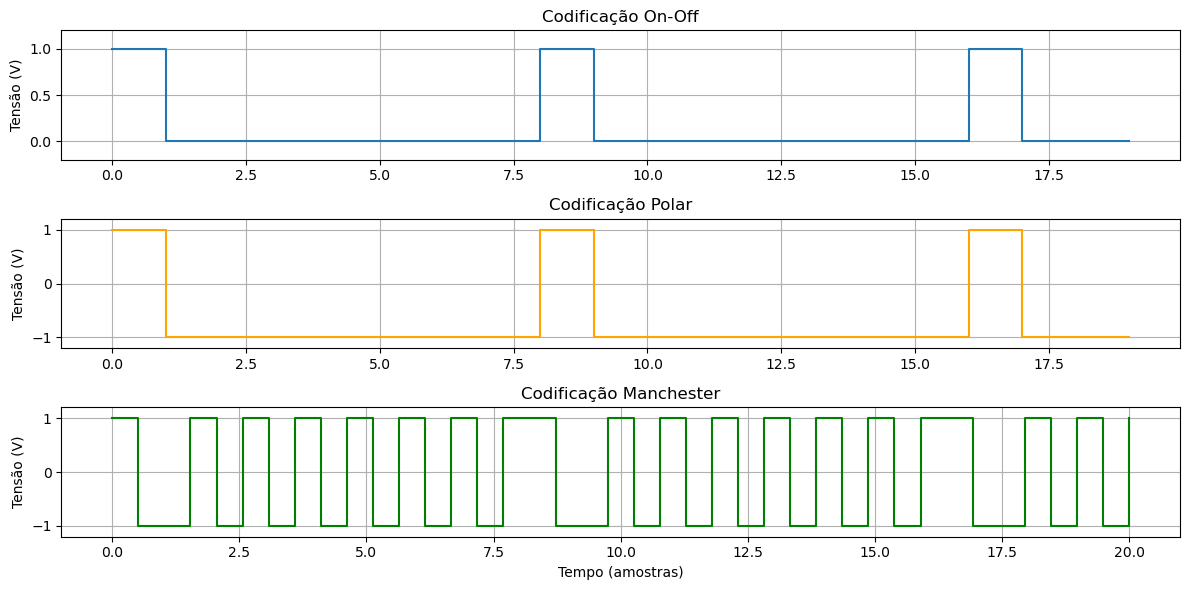

In [11]:
# Plot
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.step(tempo_on_off, sinal_on_off_plot, where='post')
plt.title('Codificação On-Off')
plt.ylim(-0.2, 1.2)
plt.ylabel('Tensão (V)')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.step(tempo_polar, sinal_polar_plot, where='post', color='orange')
plt.title('Codificação Polar')
plt.ylim(-1.2, 1.2)
plt.ylabel('Tensão (V)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.step(tempo_manchester, sinal_manchester_plot, where='post', color='green')
plt.title('Codificação Manchester')
plt.ylim(-1.2, 1.2)
plt.xlabel('Tempo (amostras)')
plt.ylabel('Tensão (V)')
plt.grid(True)

plt.tight_layout()
plt.show()